# ML 101

In [1]:
%pip install seaborn matplotlib pandas numpy

## Exploring Seaborn Plots

The main idea of Seaborn is that it provides high-level commands to create a variety of plot types useful for statistical data exploration, and even some statistical model fitting.

Let's take a look at a few of the datasets and plot types available in Seaborn. Note that all of the following *could* be done using raw Matplotlib commands (this is, in fact, what Seaborn does under the hood) but the Seaborn API is much more convenient.

### Pair plots

When you generalize joint plots to datasets of larger dimensions, you end up with *pair plots*. This is very useful for exploring correlations between multidimensional data, when you'd like to plot all pairs of values against each other.

We'll demo this with the well-known Iris dataset, which lists measurements of petals and sepals of three iris species:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()

iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Visualizing the multidimensional relationships among the samples is as easy as calling ``sns.pairplot``:

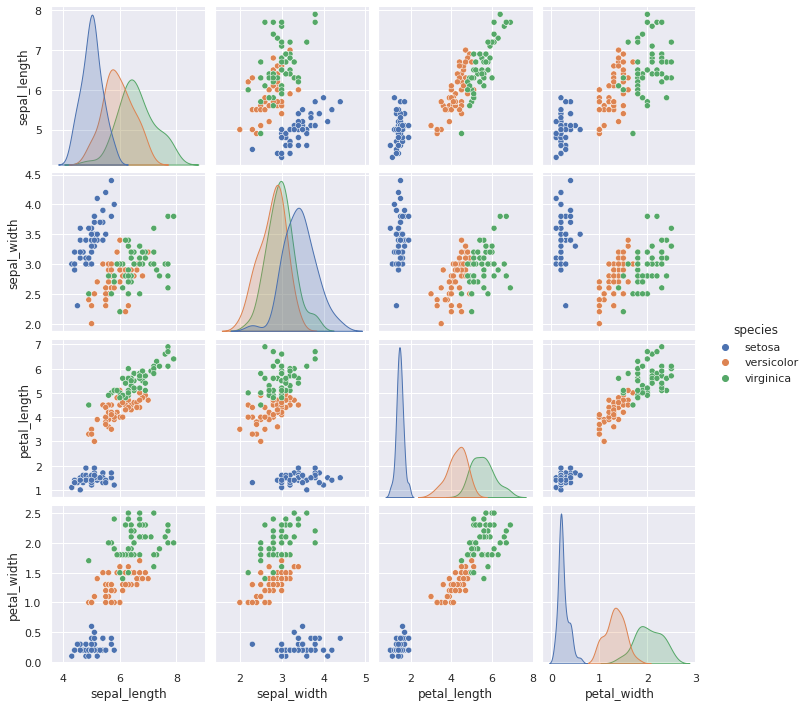

In [3]:
sns.pairplot(iris, hue='species', height=2.5)

### Faceted histograms

Sometimes the best way to view data is via histograms of subsets. Seaborn's ``FacetGrid`` makes this extremely simple.
We'll take a look at some data that shows the amount that restaurant staff receive in tips based on various indicator data:

In [4]:
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


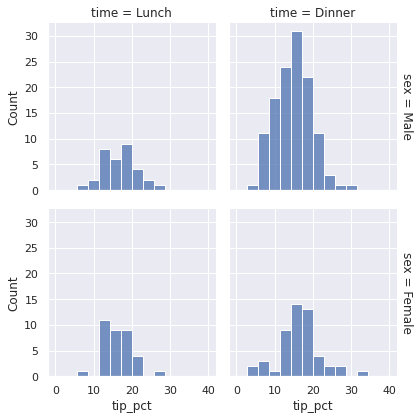

In [ ]:
tips['tip_pct'] = 100 * tips['tip'] / tips['total_bill']

grid = sns.FacetGrid(tips, row="sex", col="time", margin_titles=True)
grid.map(sns.histplot, "tip_pct", bins=np.linspace(0, 40, 15))

### Factor plots

Factor plots can be useful for this kind of visualization as well. This allows you to view the distribution of a parameter within bins defined by any other parameter:

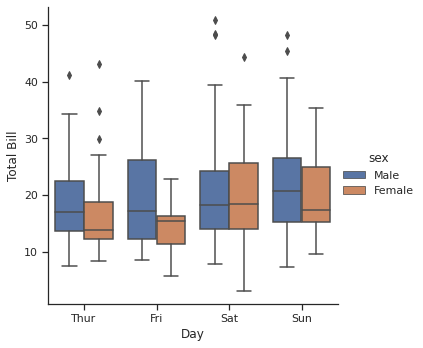

In [7]:
with sns.axes_style(style='ticks'):
    g = sns.catplot(x="day", y="total_bill", hue="sex", data=tips, kind="box")
    g.set_axis_labels("Day", "Total Bill");

### Joint distributions

Similar to the pairplot we saw earlier, we can use ``sns.jointplot`` to show the joint distribution between different datasets, along with the associated marginal distributions:

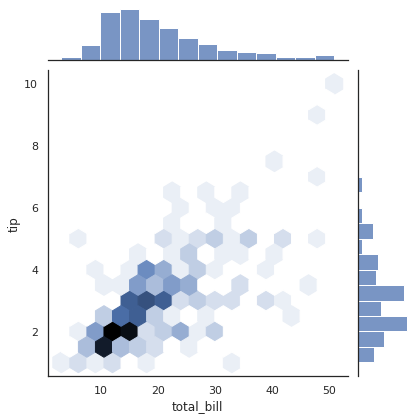

In [10]:
with sns.axes_style('white'):
    sns.jointplot(x="total_bill", y="tip", data=tips, kind='hex')

The joint plot can even do some automatic kernel density estimation and regression:

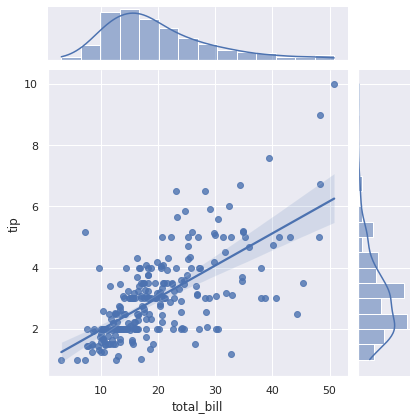

In [13]:
sns.jointplot(x="total_bill", y="tip", data=tips, kind='reg')

### Bar plots

Time series can be plotted using ``sns.factorplot``. In the following example, we'll use the Planets data that we first saw in [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb):

In [14]:
planets = sns.load_dataset('planets')
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


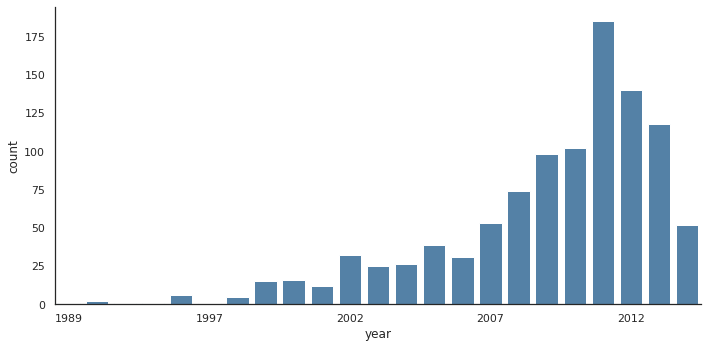

In [15]:
with sns.axes_style('white'):
    g = sns.catplot(x="year", data=planets, aspect=2, kind="count", color='steelblue')
    g.set_xticklabels(step=5)

We can learn more by looking at the *method* of discovery of each of these planets:

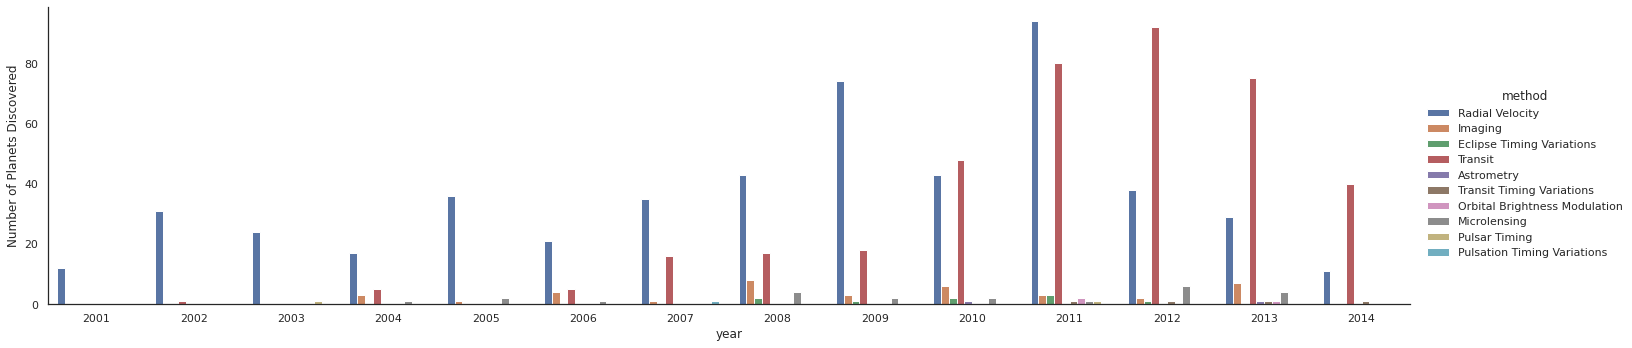

In [16]:
with sns.axes_style('white'):
    g = sns.catplot(x="year", data=planets, aspect=4.0, kind='count', hue='method', order=range(2001, 2015))
    g.set_ylabels('Number of Planets Discovered')

For more information on plotting with Seaborn, see the [Seaborn documentation](http://seaborn.pydata.org/), a [tutorial](http://seaborn.pydata.org/
tutorial.htm), and the [Seaborn gallery](http://seaborn.pydata.org/examples/index.html).

## Example: Exploring Marathon Finishing Times

Here we'll look at using Seaborn to help visualize and understand finishing results from a marathon.

In [17]:
data = pd.read_csv('https://raw.githubusercontent.com/jakevdp/marathon-data/master/marathon-data.csv')
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


By default, Pandas loaded the time columns as Python strings (type ``object``); we can see this by looking at the ``dtypes`` attribute of the DataFrame:

In [18]:
data.dtypes

age        int64
gender    object
split     object
final     object
dtype: object

Let's fix this by providing a converter for the times:

In [19]:
import datetime

def convert_time(s):
    h, m, s = map(int, s.split(':'))
    return datetime.timedelta(hours=h, minutes=m, seconds=s)

data = pd.read_csv('https://raw.githubusercontent.com/jakevdp/marathon-data/master/marathon-data.csv', converters={'split':convert_time, 'final':convert_time})
data.head()

,age,gender,split,final
0,33,M,0 days 01:05:38,0 days 02:08:51
1,32,M,0 days 01:06:26,0 days 02:09:28
2,31,M,0 days 01:06:49,0 days 02:10:42
3,38,M,0 days 01:06:16,0 days 02:13:45
4,31,M,0 days 01:06:32,0 days 02:13:59


In [20]:
data.dtypes

age                 int64
gender             object
split     timedelta64[ns]
final     timedelta64[ns]
dtype: object

That looks much better. For the purpose of our Seaborn plotting utilities, let's next add columns that give the times in seconds:

In [21]:
data['split_sec'] = data['split'].astype(int) / 1E9
data['final_sec'] = data['final'].astype(int) / 1E9
data.head()

,age,gender,split,final,split_sec,final_sec
0,33,M,0 days 01:05:38,0 days 02:08:51,3938.0,7731.0
1,32,M,0 days 01:06:26,0 days 02:09:28,3986.0,7768.0
2,31,M,0 days 01:06:49,0 days 02:10:42,4009.0,7842.0
3,38,M,0 days 01:06:16,0 days 02:13:45,3976.0,8025.0
4,31,M,0 days 01:06:32,0 days 02:13:59,3992.0,8039.0


To get an idea of what the data looks like, we can plot a ``jointplot`` over the data:

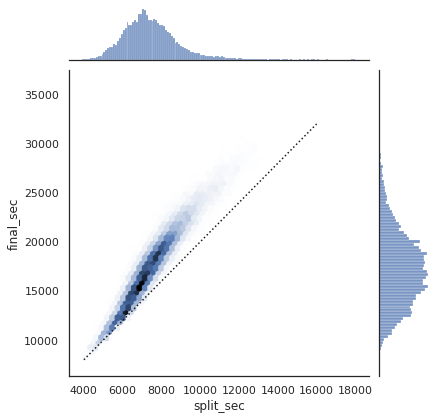

In [22]:
with sns.axes_style('white'):
    g = sns.jointplot(x="split_sec", y="final_sec", data=data, kind='hex')
    g.ax_joint.plot(np.linspace(4000, 16000), np.linspace(8000, 32000), ':k')

The dotted line shows where someone's time would lie if they ran the marathon at a perfectly steady pace. The fact that the distribution lies above this indicates (as you might expect) that most people slow down over the course of the marathon.
If you have run competitively, you'll know that those who do the opposite—run faster during the second half of the race—are said to have "negative-split" the race.

Let's create another column in the data, the split fraction, which measures the degree to which each runner negative-splits or positive-splits the race:

In [23]:
data['split_frac'] = 1 - 2 * data['split_sec'] / data['final_sec']
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac
0,33,M,0 days 01:05:38,0 days 02:08:51,3938.0,7731.0,-0.018756
1,32,M,0 days 01:06:26,0 days 02:09:28,3986.0,7768.0,-0.026262
2,31,M,0 days 01:06:49,0 days 02:10:42,4009.0,7842.0,-0.022443
3,38,M,0 days 01:06:16,0 days 02:13:45,3976.0,8025.0,0.009097
4,31,M,0 days 01:06:32,0 days 02:13:59,3992.0,8039.0,0.006842


Where this split difference is less than zero, the person negative-split the race by that fraction.
Let's do a distribution plot of this split fraction:

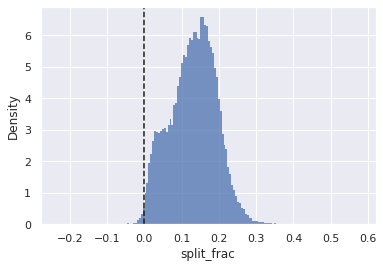

In [24]:
sns.histplot(data['split_frac'], kde=False, stat="density", linewidth=0)
plt.axvline(0, color="k", linestyle="--")

In [ ]:
sum(data.split_frac < 0)

251

Out of nearly 40,000 participants, there were only 250 people who negative-split their marathon.

Let's see whether there is any correlation between this split fraction and other variables. We'll do this using a ``pairgrid``, which draws plots of all these correlations:

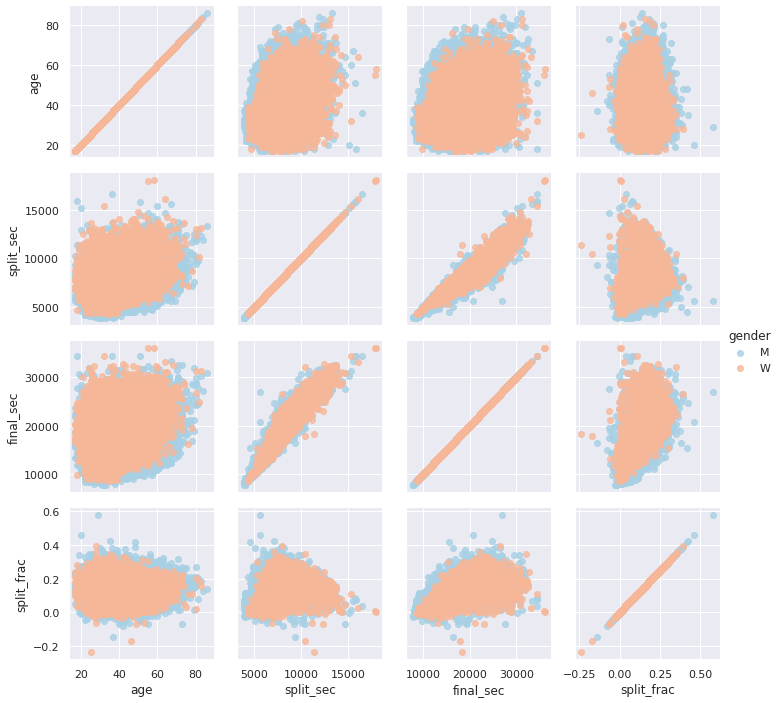

In [25]:
g = sns.PairGrid(data, vars=['age', 'split_sec', 'final_sec', 'split_frac'], hue='gender', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

It looks like the split fraction does not correlate particularly with age, but does correlate with the final time: faster runners tend to have closer to even splits on their marathon time.
(We see here that Seaborn is no panacea for Matplotlib's ills when it comes to plot styles: in particular, the x-axis labels overlap. Because the output is a simple Matplotlib plot, however, the methods in [Customizing Ticks](04.10-Customizing-Ticks.ipynb) can be used to adjust such things if desired.)

The difference between men and women here is interesting. Let's look at the histogram of split fractions for these two groups:

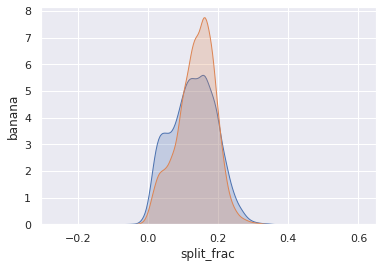

In [28]:
sns.kdeplot(data.split_frac[data.gender=='M'], label='men', shade=True)
sns.kdeplot(data.split_frac[data.gender=='W'], label='women', shade=True)
plt.xlabel('split_frac');

The interesting thing here is that there are many more men than women who are running close to an even split!
This almost looks like some kind of bimodal distribution among the men and women. Let's see if we can suss-out what's going on by looking at the distributions as a function of age.

A nice way to compare distributions is to use a *violin plot*

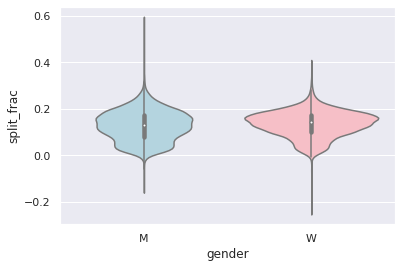

In [29]:
sns.violinplot(x = "gender", y = "split_frac", data=data, palette=["lightblue", "lightpink"]);

This is yet another way to compare the distributions between men and women.

Let's look a little deeper, and compare these violin plots as a function of age. We'll start by creating a new column in the array that specifies the decade of age that each person is in:

In [30]:
data['age_dec'] = data.age.map(lambda age: 10 * (age // 10))
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac,age_dec
0,33,M,0 days 01:05:38,0 days 02:08:51,3938.0,7731.0,-0.018756,30
1,32,M,0 days 01:06:26,0 days 02:09:28,3986.0,7768.0,-0.026262,30
2,31,M,0 days 01:06:49,0 days 02:10:42,4009.0,7842.0,-0.022443,30
3,38,M,0 days 01:06:16,0 days 02:13:45,3976.0,8025.0,0.009097,30
4,31,M,0 days 01:06:32,0 days 02:13:59,3992.0,8039.0,0.006842,30


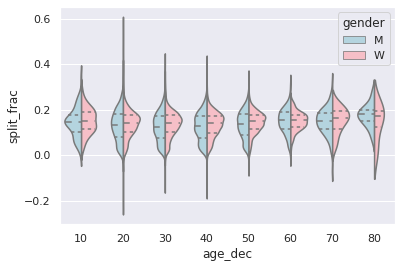

In [31]:
men = (data.gender == 'M')
women = (data.gender == 'W')

with sns.axes_style(style=None):
    sns.violinplot(x="age_dec", y="split_frac", hue="gender", data=data, split=True, inner="quartile", palette=["lightblue", "lightpink"]);

Looking at this, we can see where the distributions of men and women differ: the split distributions of men in their 20s to 50s show a pronounced over-density toward lower splits when compared to women of the same age (or of any age, for that matter).

Also surprisingly, the 80-year-old women seem to outperform *everyone* in terms of their split time. This is probably due to the fact that we're estimating the distribution from small numbers, as there are only a handful of runners in that range:

In [32]:
(data.age > 80).sum()

7

Back to the men with negative splits: who are these runners? Does this split fraction correlate with finishing quickly? We can plot this very easily. We'll use ``regplot``, which will automatically fit a linear regression to the data:

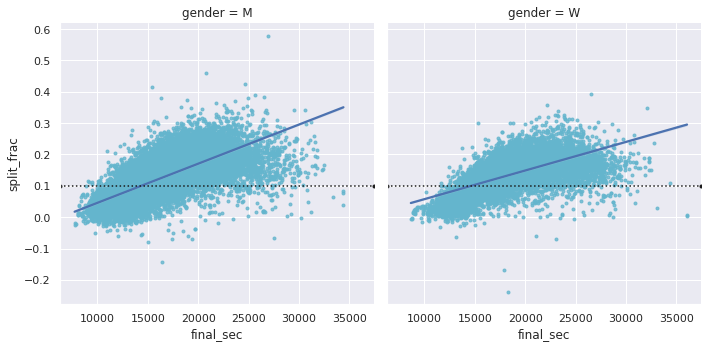

In [33]:
g = sns.lmplot(x='final_sec', y='split_frac', col='gender', data=data, markers=".", scatter_kws=dict(color='c'))
g.map(plt.axhline, y=0.1, color="k", ls=":");

Apparently the people with fast splits are the elite runners who are finishing within ~15,000 seconds, or about 4 hours. People slower than that are much less likely to have a fast second split.